# Synthetic Data

In [1]:
%pylab inline
import random
import json

from keras.layers import Conv1D, Flatten, Dense, Input, MaxPooling1D, UpSampling1D, Reshape, Dropout, Embedding
from keras.models import Model

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
json_dir = r'../../Touch Into Text/JSON/'
json_filename = ['Gently_Punching.JSON', 'Firmly_Punching.JSON', 'Hard_Punching.JSON',
                 'Slow_Stroking.JSON', 'Moderate_Stroking.JSON', 'Rapidly_Stroking.JSON',
                 'Gently_Squeezing.JSON', 'Firmly_Squeezing.JSON', 'Hard_Squeezing.JSON']
score_num = 59


LIWC_score = np.zeros((len(json_filename), score_num))

for i in range(len(json_filename)):
    with open(json_dir + json_filename[i]) as json_data:
        temp = json.load(json_data)['receptiviti_scores']['percentiles']
        index = 0
        for j in temp:
            LIWC_score[i][index] = temp[j]
            index += 1

In [3]:
PUNCHING = 1
STROKING = 2
SQUEEZING = 3
ROLLING = 4

total_time = 400

def Make_Data(t):
    x = np.zeros((total_time, 6))
    y = np.zeros(score_num)
    if t == PUNCHING:
        punched = random.randrange(6)
        temp = random.randrange(200)
        for sensor in range(6):
            if sensor != punched:
                for time in range(total_time):
                    x[time][sensor] = temp
                    
        r = random.randint(10, 25)
        if r <= 15:
            y = LIWC_score[0]
        elif r <= 20:
            y = LIWC_score[1]
        else:
            y = LIWC_score[2]
        
        punched_time = random.randrange(300)
        for time in range(total_time):
            x[time][punched] = 0
        for time in range(punched_time, punched_time + 50):
            x[time][punched] = x[time-1][punched] + r
        for i in range(punched_time + 50, punched_time + 100):
            x[time][punched] = x[time-1][punched] - r
            
    elif t == STROKING:
        stroked = random.randrange(6)
        touched = stroked - 2 if stroked > 3 else stroked + 2
        r = random.randrange(250)
        
        stroked_time = random.randint(10, 70)
        stop_time = random.randint(20, 40)
        if stroked_time <= 30:
            y = LIWC_score[3]
        elif stroked_time <= 50:
            y = LIWC_score[4]
        else:
            y = LIWC_score[5]
        
        t1 = stroked_time
        t2 = stop_time
        for time in range(total_time):
            x[time][touched] = 100
            if t2 != 0:
                t2 -= 1
            elif t1 != 0:
                t1 -= 1
                x[time][stroked] = r
            else:
                t1 = stroked_time
                t2 = stop_time
                
    elif t == SQUEEZING:
        not_squeezed = random.randrange(6)
        r = random.randint(10, 25) 
        if r <= 15:
            y = LIWC_score[6]
        elif r <= 20:
            y = LIWC_score[7]
        else:
            y = LIWC_score[8]
        
        squeezed_time = random.randint(20, 40)
        stop_time = random.randint(20, 40)
        t1 = squeezed_time
        t2 = stop_time
        t3 = squeezed_time
        for time in range(total_time):
            if t2 != 0:
                t2 -= 1
            elif t1 != 0:
                t1 -= 1
                for sensor in range(6):
                    if sensor != not_squeezed:
                        x[time][sensor] = x[time-1][sensor] + r
            elif t3 != 0:
                t3 -= 1
                for sensor in range(6):
                    if sensor != not_squeezed:
                        x[time][sensor] = x[time-1][sensor] - r
            else:
                t1 = squeezed_time
                t2 = stop_time
                t3 = squeezed_time

    return x / 1030., y / 100.

[ 0.99        0.01        0.52245412  0.13862848  0.0568701   0.01951434
  0.0510891   0.79422372  0.99        0.05402761  0.06690332  0.07661664
  0.01886553  0.01        0.99        0.04974297  0.18861638  0.01083741
  0.99        0.04399916  0.13477355  0.94817578  0.17741887  0.99
  0.67308034  0.21788312  0.9482281   0.99        0.76632757  0.05498433
  0.77210283  0.01        0.99        0.04506899  0.08904561  0.99
  0.18815041  0.94262601  0.01        0.01        0.03604316  0.08920225
  0.77934992  0.85168843  0.83072509  0.99        0.99        0.2742185
  0.94980646  0.78831345  0.99        0.99        0.13072529  0.04220181
  0.07434859  0.95286118  0.2535148   0.15008893  0.66694265]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


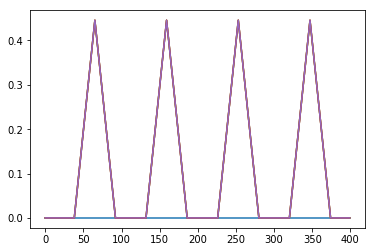

In [5]:
x_example, y_example = Make_Data(SQUEEZING)
print(y_example)
print(x_example)
plt.plot(x_example[:, :5]);

In [6]:
%%time

x_train = np.zeros((100000, 400, 6))
y_train = np.zeros((100000, score_num))
x_test = np.zeros((10000, 400, 6))
y_test = np.zeros((10000, score_num))
for i in range(100000):
    x_train[i], y_train[i] = Make_Data(random.randint(1, 3))
    if i < 10000:
        x_test[i], y_test[i] = Make_Data(random.randint(1, 3))

Wall time: 1min 21s


# Autoencoder

In [30]:
auto_input = Input(shape=(400, 6))
x = Conv1D(16,3,activation='relu',padding='same')(auto_input)
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation='relu',padding='same')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation='relu',padding='same')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)

x = Dense(29,activation='relu')(x)
embedded = x

x = Dense(1600,activation='relu')(x)
x = Reshape((50,32))(x)
x = Conv1D(32,3,activation='relu',padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32,3,activation='relu',padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16,3,activation='relu',padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(6,3,padding='same')(x)

auto = Model(auto_input, x)
auto.compile(optimizer='adam', loss='mse')
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 400, 6)            0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 400, 16)           304       
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 200, 16)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 200, 32)           1568      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 100, 32)           0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 50, 32)            0         
__________

In [31]:
auto.fit(x_train, x_train,
        epochs=3,
        batch_size=16,
        shuffle=True,
        validation_data=(x_test, x_test),
        )

Train on 100000 samples, validate on 10000 samples
Epoch 1/3
100000/100000 [==============================] - 153s - loss: 0.0021 - val_loss: 3.4785e-04
Epoch 2/3
100000/100000 [==============================] - 152s - loss: 3.1255e-04 - val_loss: 2.1800e-04
Epoch 3/3
100000/100000 [==============================] - 152s - loss: 2.0471e-04 - val_loss: 1.6100e-04


In [34]:
x_predict = auto.predict(x_test, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

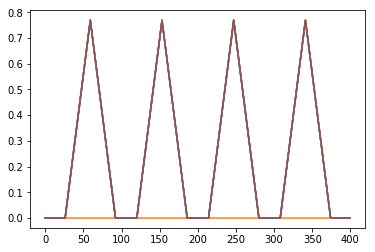

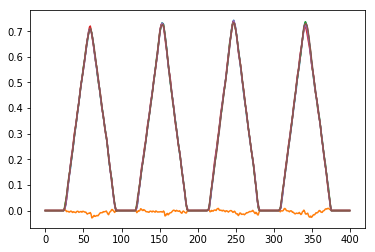

In [42]:
i = 20
plt.plot(x_test[i]);
figure()
plt.plot(x_predict[i]);

In [43]:
auto_embedded = Model(auto.input, embedded)
x_embedding = auto_embedded.predict(x_train, verbose=1)

 99968/100000 [============================>.] - ETA: 0s

# Learning Model

In [8]:
input = Input(shape=(400, 6))
x = Conv1D(24, 3, padding='same', activation='relu', strides=1)(input)
x = MaxPooling1D(4)(x)
x = Conv1D(96, 3, padding='same', activation='relu', strides=1)(x)
x = MaxPooling1D(4)(x)
x = Flatten()(x)
x = Dense(1200, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(score_num, activation='sigmoid')(x)

model = Model(input, x)

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

model.summary()

'''
model_input = Input(shape=(29,))
m = Dense(29, activation='relu')(model_input)
m = Dense(29, activation='sigmoid')(m)

model = Model(model_input, m)
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 6)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 24)           456       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 24)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 96)           7008      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 25, 96)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1200)              2881200   
__________

"\nmodel_input = Input(shape=(29,))\nm = Dense(29, activation='relu')(model_input)\nm = Dense(29, activation='sigmoid')(m)\n\nmodel = Model(model_input, m)\n"

In [9]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=2,
          shuffle=True,
          validation_data=(x_test, y_test))

Train on 100000 samples, validate on 10000 samples
Epoch 1/2
100000/100000 [==============================] - 95s - loss: 0.3708 - acc: 0.0000e+00 - val_loss: 0.3109 - val_acc: 0.0000e+00
Epoch 2/2
100000/100000 [==============================] - 87s - loss: 0.3101 - acc: 0.0000e+00 - val_loss: 0.3055 - val_acc: 0.0000e+00


In [10]:
test_size = 1000

test_data = np.zeros((test_size, 400, 6))
test_answer = np.zeros((test_size, 59))
for i in range(test_size):
    test_data[i], test_answer[i] = Make_Data(random.randint(1, 3))
predicted_answer = model.predict(test_data)

In [11]:
#loss > 0.05: 0.15084745762711865%

loss = predicted_answer - test_answer
count = 0
loss_per = 0.05
for i in range(len(predicted_answer)):
    for j in range(4):
        if abs(loss[i][j]) > loss_per:
            count += 1
            
print("loss > {}: {}%".format(loss_per, count/(score_num * test_size / 100.)))

loss > 0.05: 1.1610169491525424%


In [18]:
model.save("testing.h5")

In [17]:
print(predicted_answer[590])

[ 0.99078697  0.95306039  0.48744848  0.00730802  0.00762497  0.75248188
  0.05333087  0.74345732  0.99498391  0.99335152  0.07347013  0.05655822
  0.68520951  0.0077087   0.83759242  0.052405    0.00900561  0.01856618
  0.82244223  0.9648537   0.22487728  0.76232338  0.00922947  0.99111068
  0.00587627  0.12781     0.00199939  0.98971117  0.98489642  0.04548799
  0.0055445   0.60462338  0.01206977  0.05033058  0.00958253  0.00878851
  0.19745263  0.00494834  0.00836048  0.00887305  0.21367298  0.07337587
  0.00652741  0.15557565  0.00732388  0.33937517  0.97893584  0.00535921
  0.67141515  0.07763053  0.9935416   0.95465618  0.17150356  0.0095522
  0.00830466  0.00777938  0.99127543  0.17203955  0.97350997]
